In [ ]:
# Function to set plot dimensions for subsequent plots in the notebook
fig <- function(w,h){
    # Set global options for plot width and height using repr package settings
    options(repr.plot.width = w, repr.plot.height = h)
}

library(dplyr)
library(Seurat)
library(glue)
library(future)
library(ggplot2) # Added for my.barplot
library(ggpubr)  # Added for stylize

# Configure parallel processing
reserve <- 1 # Number of cores to leave free
plan(strategy = "multicore", workers = parallel::detectCores()-reserve)
options(future.globals.maxSize = 400*1024^3) # Increase max size for globals in future


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [ ]:
# Define the input Seurat object file path
input_rds_path <- 'input/SeuratObject_Jourdon.et.al.2023_TD0_only.rds'

# Define the main directory for saving marker results for RG cells
markers_dir <- 'markers_pairwise/RG/'
# Define the subdirectory for pairwise comparisons within the markers directory
markers_subdir <- paste0(markers_dir, 'pairwise/')
# Create the subdirectory, recursively if needed, suppressing warnings if it already exists
dir.create(markers_subdir, recursive = T, showWarnings = F)

# Define metadata variables of interest for plotting/analysis (used in DimPlot)
int.vars <- c('library','individual','family','family.grouping','ASD.diagnosis','stage','cell.cluster','cell.type')

In [ ]:
# Function to apply a consistent style to ggplot objects
stylize <- function(p){

    require(ggpubr) # Ensure ggpubr is loaded (though ideally loaded at the start)
    
    # Apply light theme and publication-ready labels
    p + theme_light() + 
        labs_pubr()
}

# Function to create a customized bar plot using ggplot2
my.barplot <- function(metadata, var=NULL, fill_var=NULL, column_var=NULL, row_var=NULL, palette = NULL,
                       scales = 'free', space = 'fixed', flip=F, switch = 'y'){

    require(ggplot2) # Ensure ggplot2 is loaded (though ideally loaded at the start)

    # Create base ggplot object: bar plot with specified y-axis variable and fill variable
    p <- ggplot(metadata, 
                aes_string(
                    y=var, # Variable for y-axis (counts will be calculated by geom_bar)
                    fill=fill_var)) + # Variable to map to fill color
        geom_bar() # Create the bar geometry (counts items)

    # Apply custom color palette if provided
    if (!is.null(fill_var) & !is.null(palette)){
        p <- p + scale_fill_manual(values = palette)
    }

    # Flip coordinates if requested (makes bars horizontal)
    if (flip){
        p <- p + coord_flip()
    }
    
    # Add faceting if row or column variables are specified
    if (!(is.null(column_var) & is.null(row_var))){
        
        # Prepare row faceting variable if provided
        if (!is.null(row_var)){
            # Note: Modifying data within the plot object like this is generally discouraged.
            # It's usually better to modify the input dataframe beforehand.
            p$data$row_var <- p$data[,row_var]
            row_var <- vars(row_var) # Use vars() for facet_grid syntax
        } else {
            row_var <- NULL
        }
        # Prepare column faceting variable if provided
        if (!is.null(column_var)){
            # Note: Modifying data within the plot object like this is generally discouraged.
            p$data$column_var <- p$data[,column_var]
            column_var <- vars(column_var) # Use vars() for facet_grid syntax
        } else {
            column_var <- NULL   
        }
        # print(row_var) # Debugging print (commented out)
        # print(column_var) # Debugging print (commented out)
        # Apply facet_grid with specified row/column variables, scales, space, and label switch
        p <- p + facet_grid(rows = row_var, cols = column_var, scales = scales, space = space, switch = switch)
    }

    # Return the final ggplot object
    return(p)
    
}

### Load data

In [ ]:
# Load the Seurat object using the defined path
obj <- readRDS(input_rds_path)
obj

An object of class Seurat 
19035 features across 231887 samples within 1 assay 
Active assay: RNA (19035 features, 0 variable features)
 1 layer present: counts

Loading required package: ggpubr

Loading required package: ggplot2

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


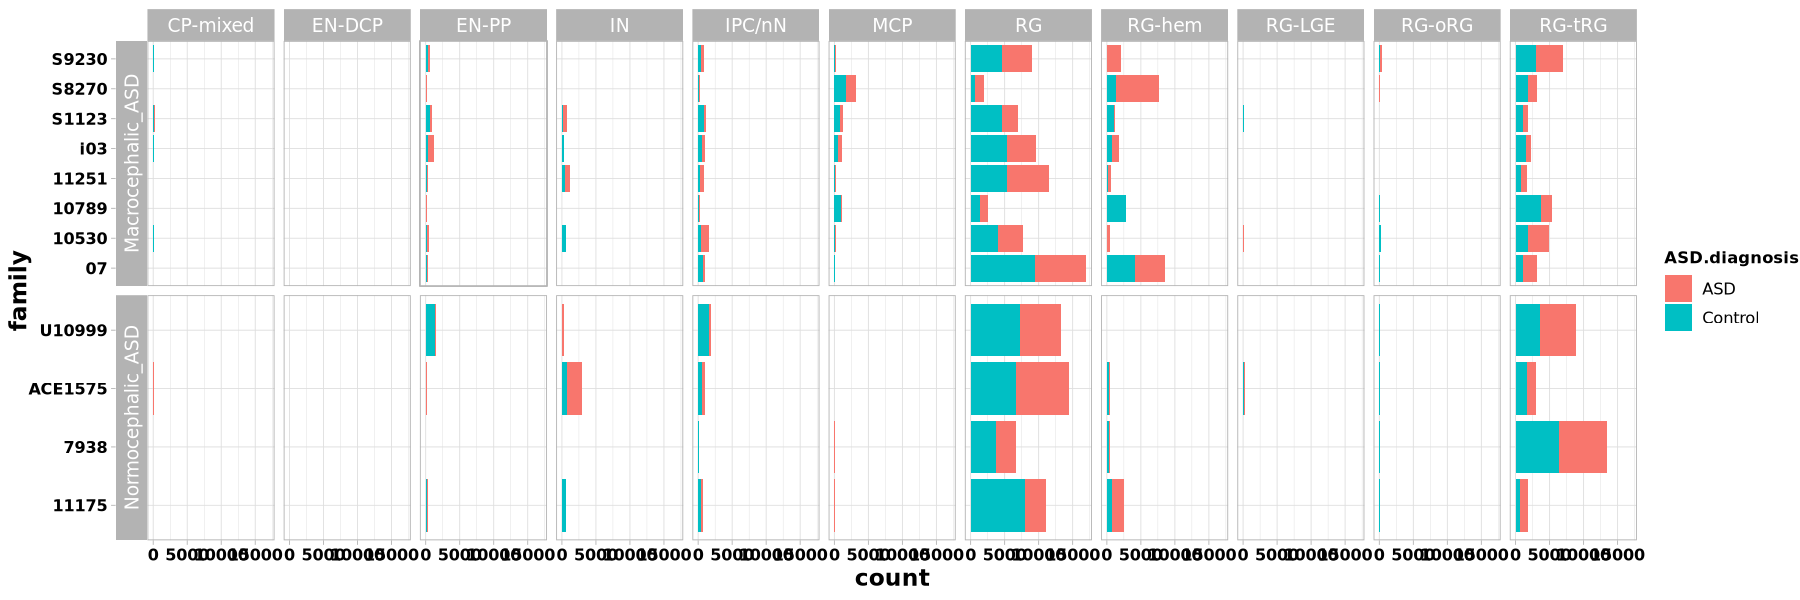

In [ ]:
fig(15,5)
# p1: Bar plot showing cell counts per family, filled by ASD diagnosis, faceted by cell type and family grouping
p1 <- my.barplot(obj@meta.data, var = 'family', fill_var='ASD.diagnosis', column_var = 'cell.type', row_var = 'family.grouping', flip=F, scales='free_y') %>% stylize()
p1

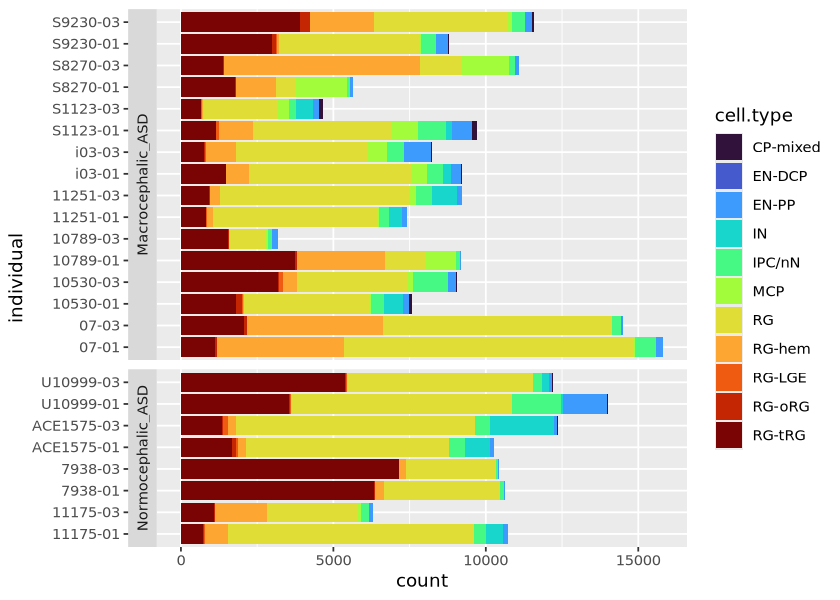

In [ ]:
fig(7,5)
# p2: Bar plot showing cell counts per individual, filled by cell type, faceted by family grouping
p2 <- my.barplot(obj@meta.data, var = 'individual', fill_var='cell.type', row_var = 'family.grouping', flip=F, scales='free_y', space='free') + scale_fill_viridis_d(option='turbo')
p2

#### Subset and preprocess

In [ ]:
rg.obj <- CreateSeuratObject(counts = subset(obj, cell.type == 'RG')[['RNA']]$counts, assay = 'RNA', min.cells = 0, min.features = 0, meta.data = subset(obj, cell.type == 'RG')@meta.data)
rg.obj

An object of class Seurat 
19035 features across 112008 samples within 1 assay 
Active assay: RNA (19035 features, 0 variable features)
 1 layer present: counts

In [8]:
rg.obj <- SCTransform(rg.obj, verbose = TRUE, return.only.var.genes = FALSE)
rg.obj

Running SCTransform on assay: RNA

Running SCTransform on layer: counts

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Variance stabilizing transformation of count matrix of size 18583 by 112008

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 713 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18583 genes

Computing corrected count matrix for 18583 genes

Calculating gene attributes

Wall clock passed: Time difference of 7.392109 mins

Determine variable features

Centering data matrix

Getting residuals for block 1(of 23) for counts dataset

Getting residuals for block 2(of 23) for counts dataset

Getting residuals for block 3(of 23) for counts dataset

Getting residuals for block 4(of 23) for counts dataset

Getting residuals for block 5(of 23) for counts dataset

Getting residuals for block 6(of 23) for co

An object of class Seurat 
37618 features across 112008 samples within 2 assays 
Active assay: SCT (18583 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA

In [9]:
# These are now standard steps in the Seurat workflow for visualization and clustering
rg.obj <- RunPCA(rg.obj, verbose = T)
rg.obj <- RunUMAP(rg.obj, dims = 1:30, verbose = T)

rg.obj <- FindNeighbors(rg.obj, dims = 1:30, verbose = T)
rg.obj <- FindClusters(rg.obj, verbose = T)

PC_ 1 
Positive:  FTL, ID4, EEF2, EEF1A1, FABP7, NACA, GABPB1-AS1, AL139246.5, HES5, MIAT 
	   PTPRZ1, HSP90AB1, EIF3E, IGDCC3, LINC00461, PLP1, NEAT1, RACK1, C1orf61, ZFAS1 
	   TMSB4X, WSB1, CCND2, MAPK10, SRGAP3, ARGLU1, PABPC1, FGFBP3, SCG5, EFNB2 
Negative:  UBE2C, CENPF, TOP2A, TUBB4B, HMGB2, KPNA2, PTTG1, CCNB1, UBE2S, HIST1H4C 
	   TPX2, MKI67, ASPM, CDC20, NUSAP1, CKS2, CCNB2, DLGAP5, CKS1B, TUBA1C 
	   CDK1, PLK1, ARL6IP1, CDKN3, BIRC5, HMMR, SGO2, CENPE, H2AFX, CCNA2 
PC_ 2 
Positive:  ID3, ID1, TPBG, CRABP1, WLS, RSPO3, ZIC2, SFRP2, TRH, RSPO2 
	   NR2F1, PTN, WNT7B, C1orf61, ID2, NR2F2, CENPF, ZIC1, CNTNAP2, CDH2 
	   IGFBPL1, RSPO1, FOS, EPHA7, YWHAZ, PAX3, AL359091.1, TOP2A, HSP90B1, UBE2C 
Negative:  MTRNR2L8, HIST1H4C, DLK1, MEG3, LINC01551, SFRP1, HES5, MGST1, LHX2, GAPDH 
	   EEF1A1, FABP5, HCRT, MTRNR2L12, FOXG1, EEF1B2, RACK1, PCLAF, PTMA, CKB 
	   HIST1H1B, FABP7, HES4, PPA1, HMGA1, MDK, MEST, DUT, TUBA1B, TYMS 
PC_ 3 
Positive:  TUBA1B, ACTB, PCLAF, H2AFZ, FTL, G

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 112008
Number of edges: 3844723

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9347
Number of communities: 34
Elapsed time: 35 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


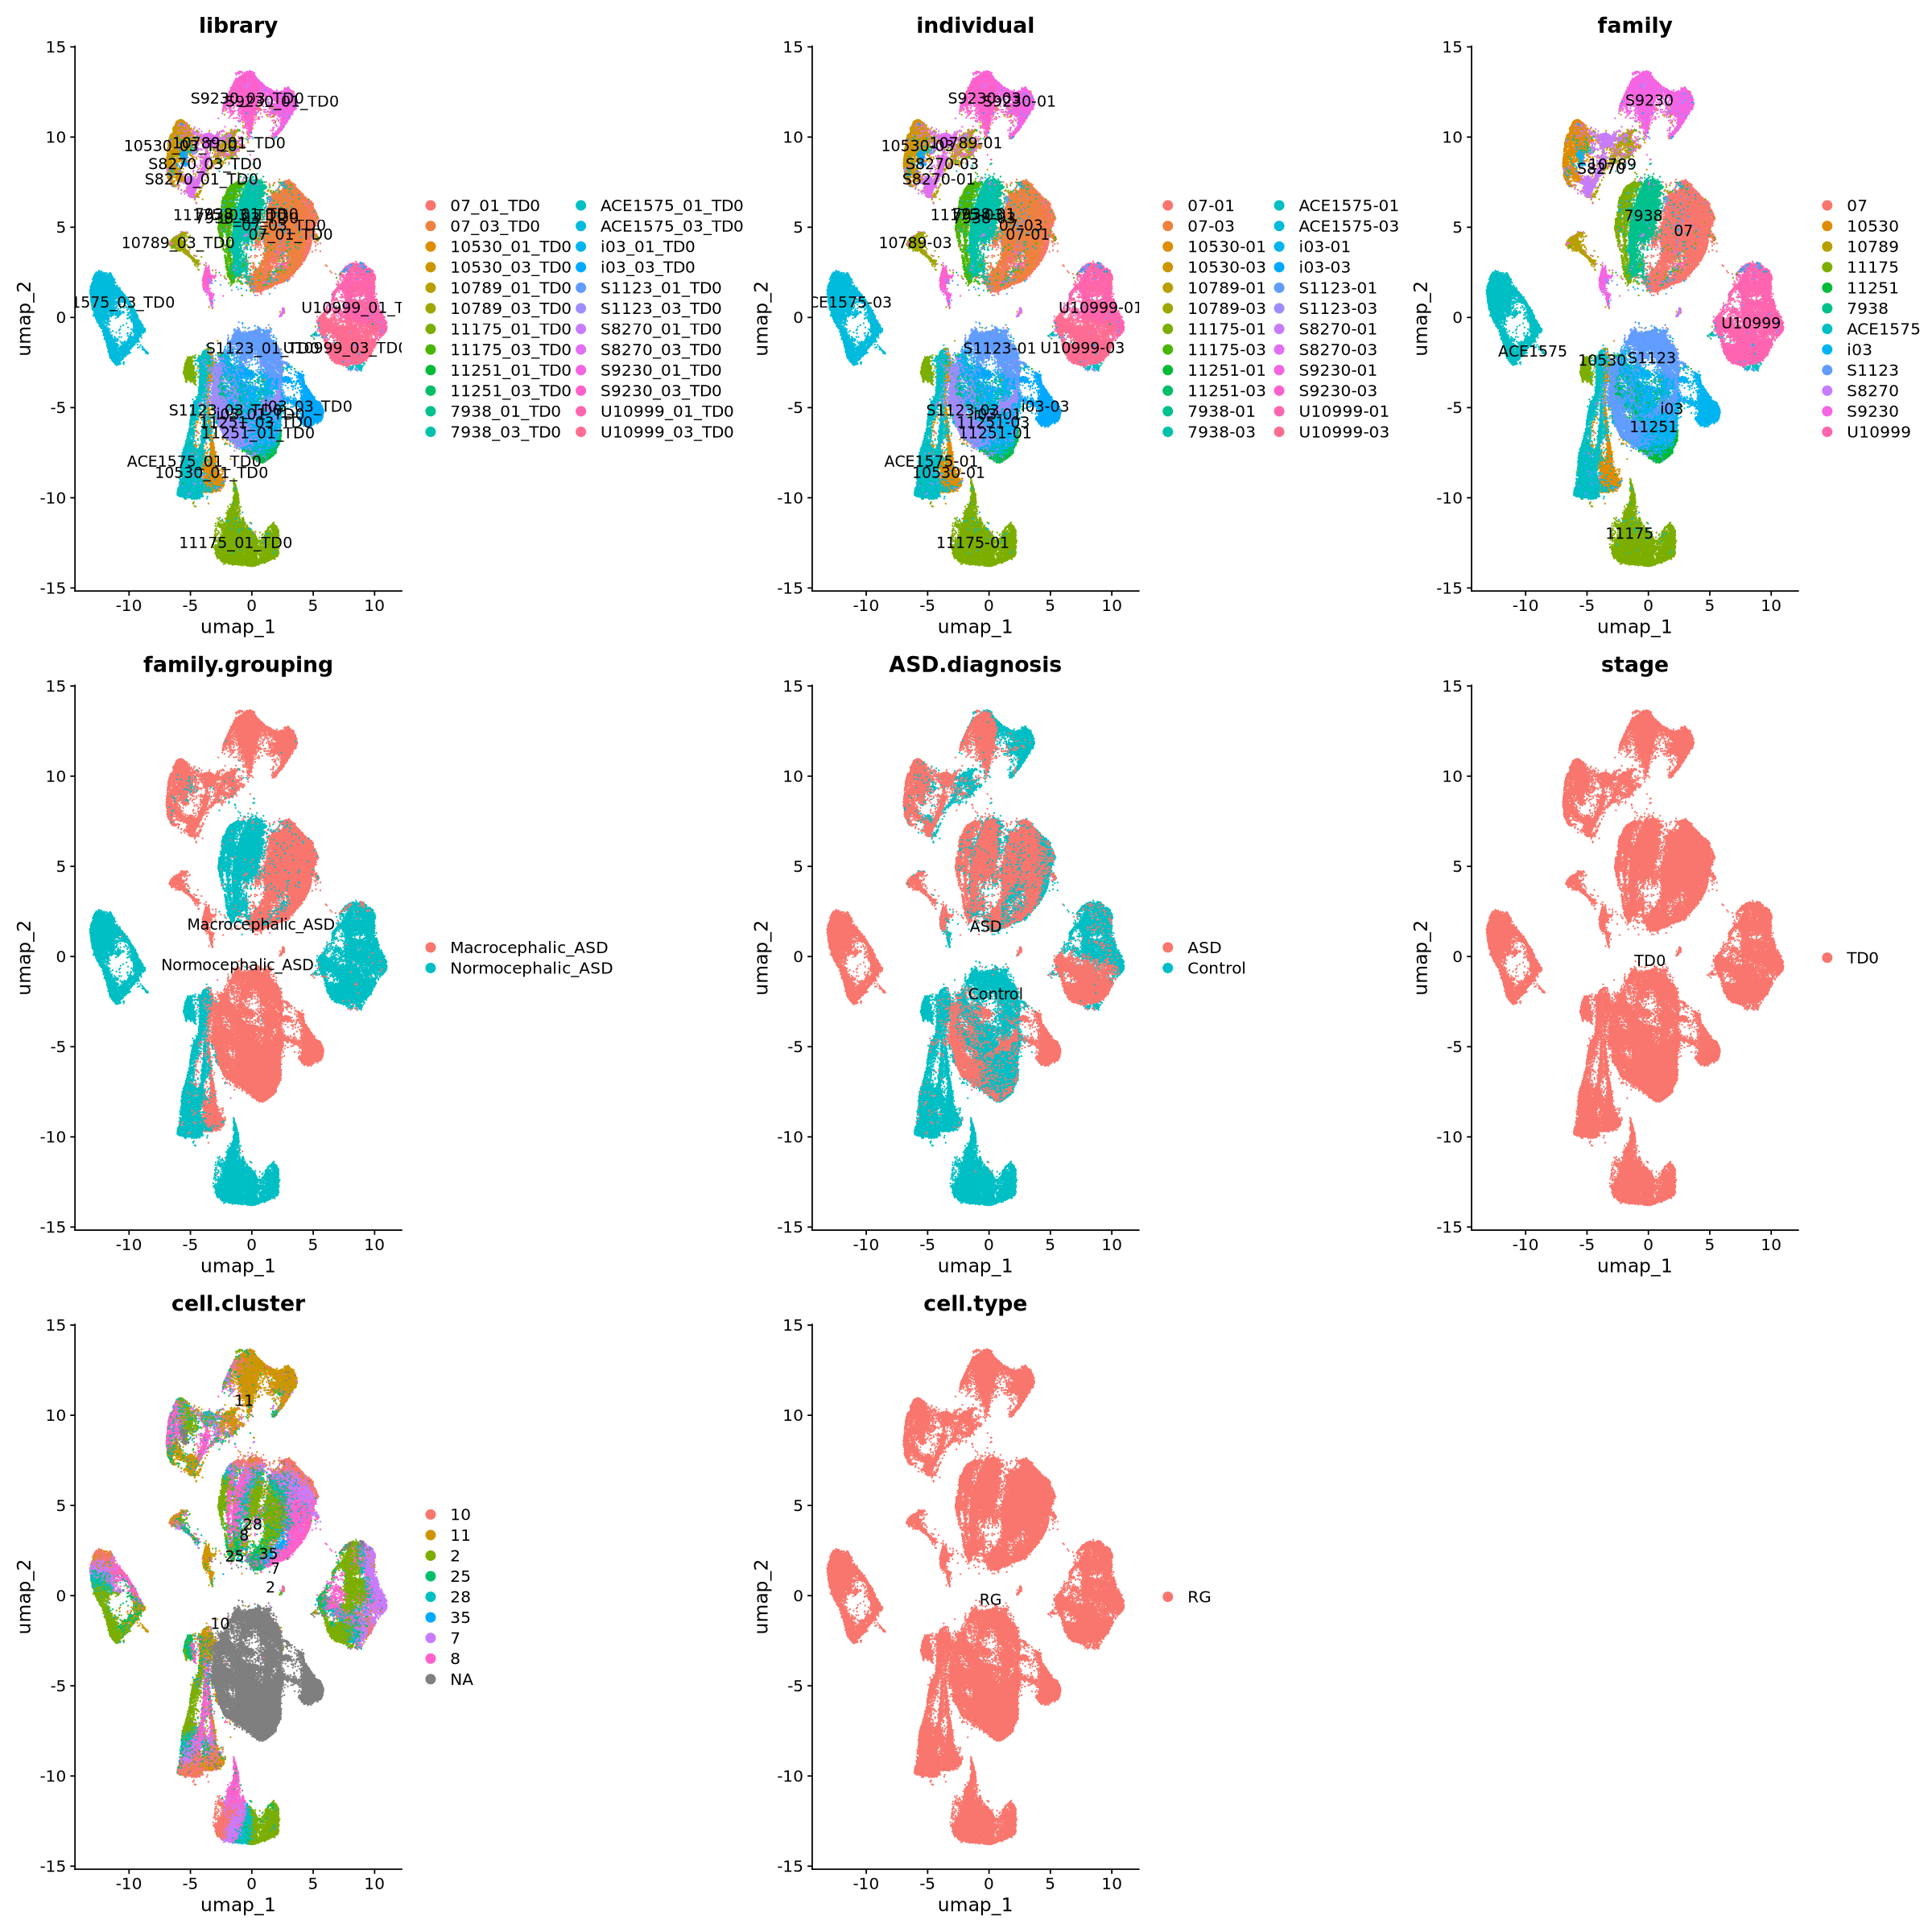

In [10]:
fig(20,20)
DimPlot(rg.obj, label = TRUE, raster = F, group.by = int.vars)

In [ ]:
rg.obj

An object of class Seurat 
37618 features across 112008 samples within 2 assays 
Active assay: SCT (18583 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap